### Loading data

In [1]:
import yfinance as yf

def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-10-22')
    return tickerDf.iloc[:, :5]

apple_df = get_price_data('AAPL')
apple_df = apple_df.drop(columns = ['Open','High', 'Low', 'Volume'])
apple_df.head()

,Close
Date,
2017-01-03 00:00:00-05:00,27.059315
2017-01-04 00:00:00-05:00,27.029022
2017-01-05 00:00:00-05:00,27.166471
2017-01-06 00:00:00-05:00,27.469341
2017-01-09 00:00:00-05:00,27.720938


Since the data is daily, the time series has large fluctuations and some outliers. You can move to a weekly interval to smooth out the series and see the trend better.

In [2]:
apple_df = apple_df.resample('W').mean()

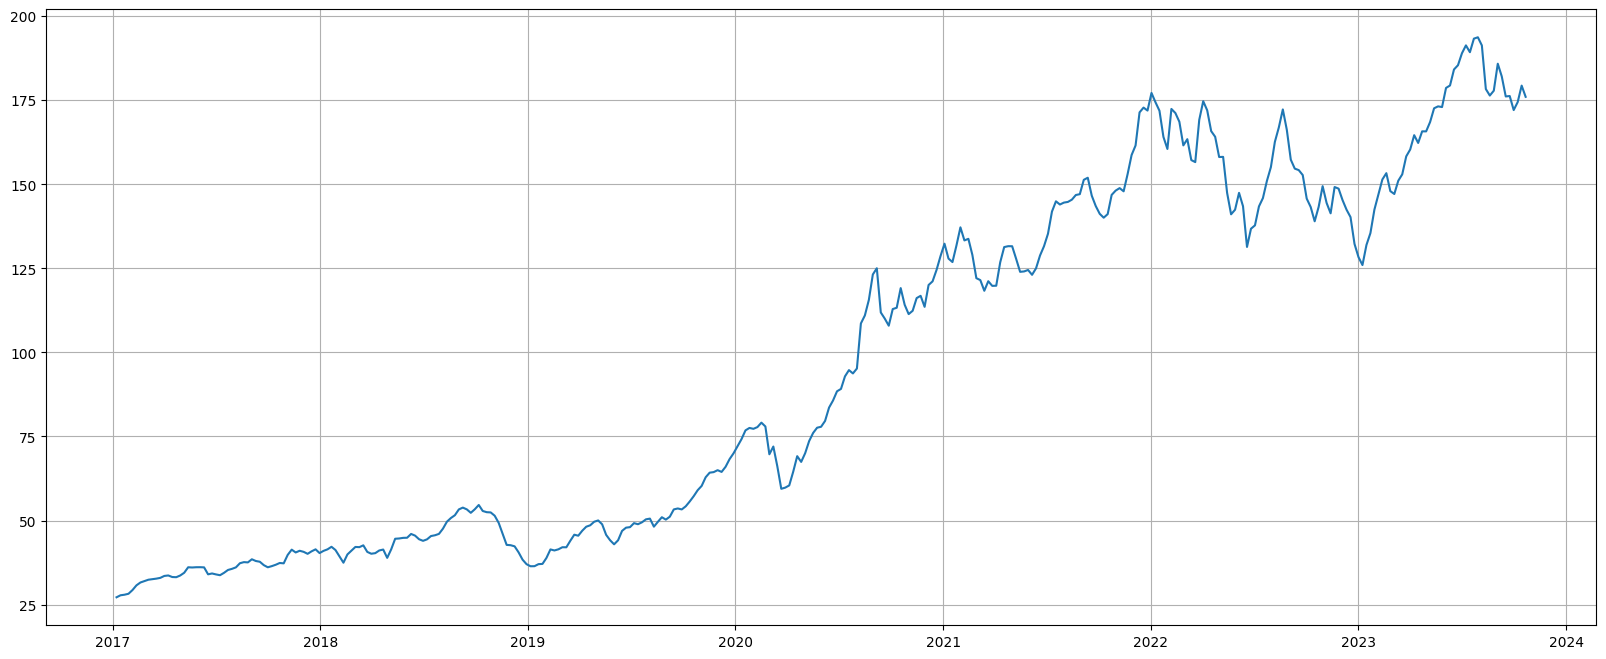

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(apple_df['Close'], linewidth=1.5)
plt.grid(True)
plt.show()

In [4]:
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook
import statsmodels as sm
import statsmodels.tsa.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import numpy as np

warnings.filterwarnings('ignore')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Let's check the original series for stationarity

Stationary series are easier to predict, since future statistical characteristics will not differ from current observed ones.

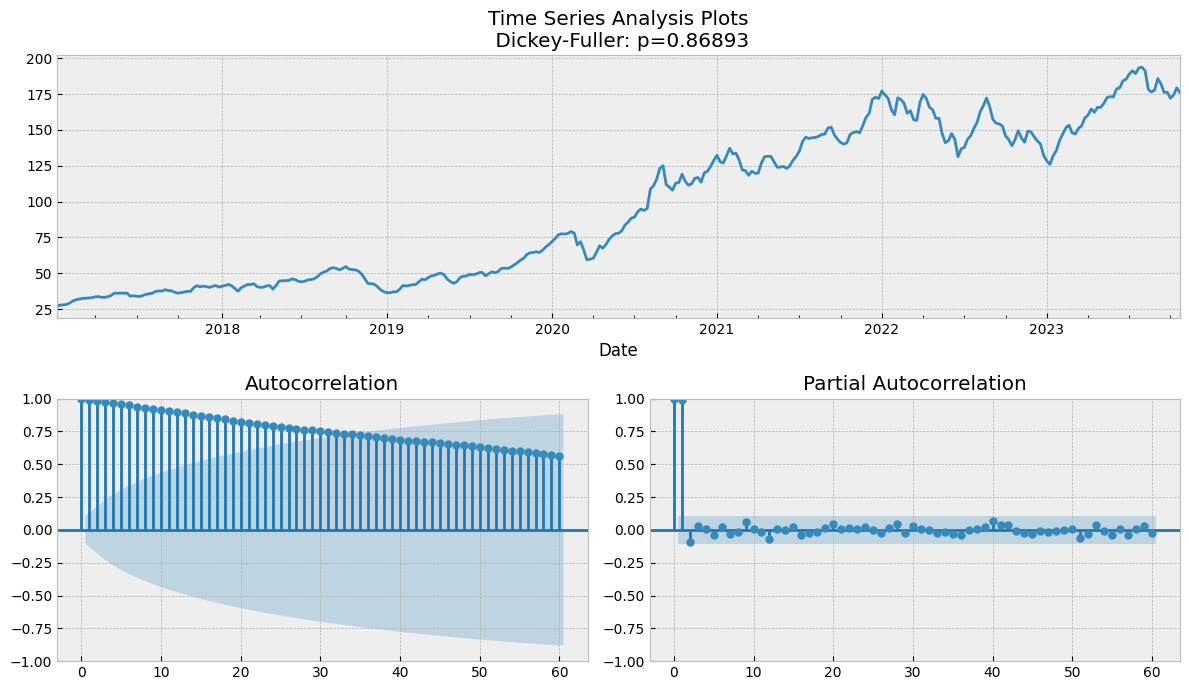

In [5]:
tsplot(apple_df.Close, lags=60)

By shifting the series by first differences, we obtained a stationary series, thus, the original series is integrated of the first order.

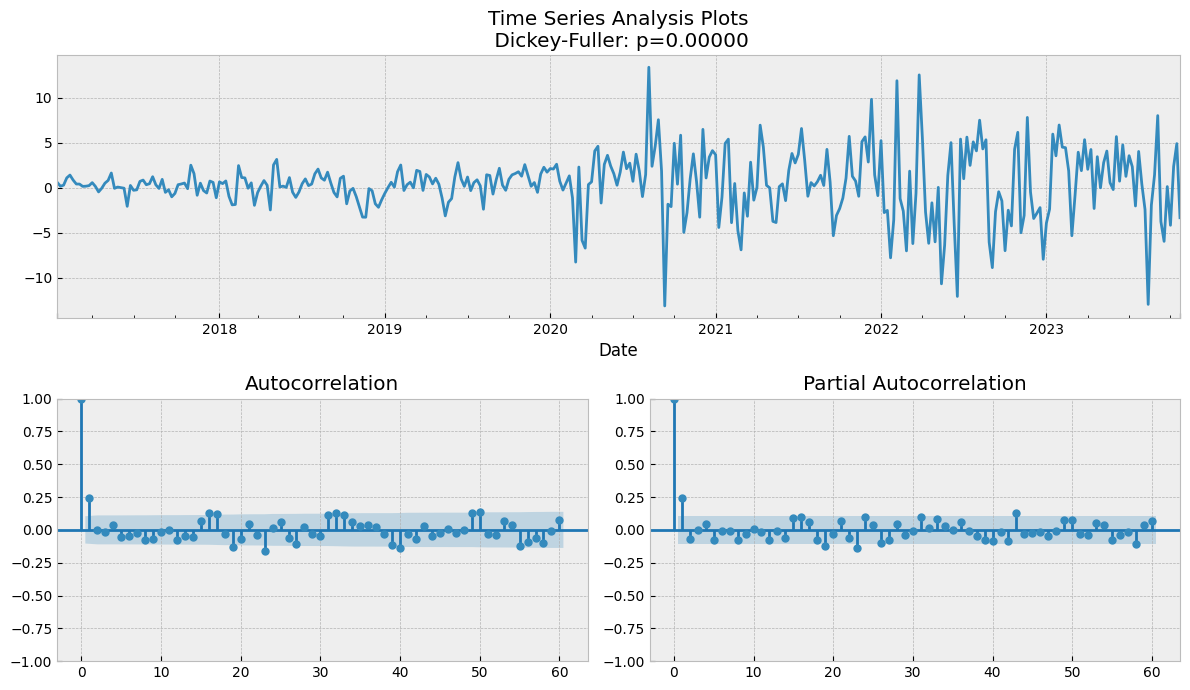

In [6]:
ts_diff = apple_df.Close - apple_df.Close.shift(1)
tsplot(ts_diff[1:], lags=60)

Since the first order of integration was a stationary series, the parameters d and D are equal to 1. The remaining parameters will be sorted over the grid.

In [7]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)
s = 24 

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

Let's carry out a search of parameters with optimization according to the AIC metric

In [8]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.sarimax.SARIMAX(data, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

Let's divide the time series into training and test samples

In [9]:
len_test = 20 
train = apple_df[:-len_test]
test = apple_df[-len_test:]

In [10]:
%%time
result_table = optimizeSARIMA(train, parameters_list, d, D, s)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2h 41min 44s, sys: 2h 44min 12s, total: 5h 25min 56s
Wall time: 29min 36s


In [11]:
result_table.head()

,parameters,aic
0,"(2, 3, 4, 0)",1687.073883
1,"(0, 1, 4, 0)",1687.851185
2,"(3, 2, 4, 0)",1688.389273
3,"(1, 0, 4, 0)",1688.519389
4,"(3, 3, 4, 0)",1688.603692


SARIMA model with the best parameters

In [12]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.sarimax.SARIMAX(train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  335
Model:             SARIMAX(2, 1, 3)x(4, 1, [], 24)   Log Likelihood                -833.537
Date:                             Wed, 01 Nov 2023   AIC                           1687.074
Time:                                     12:45:30   BIC                           1724.440
Sample:                                 01-08-2017   HQIC                          1702.011
                                      - 06-04-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1335      0.032     35.699      0.000       1.071       1.196
ar.L2         -0.9227      

Prediction for test sample length

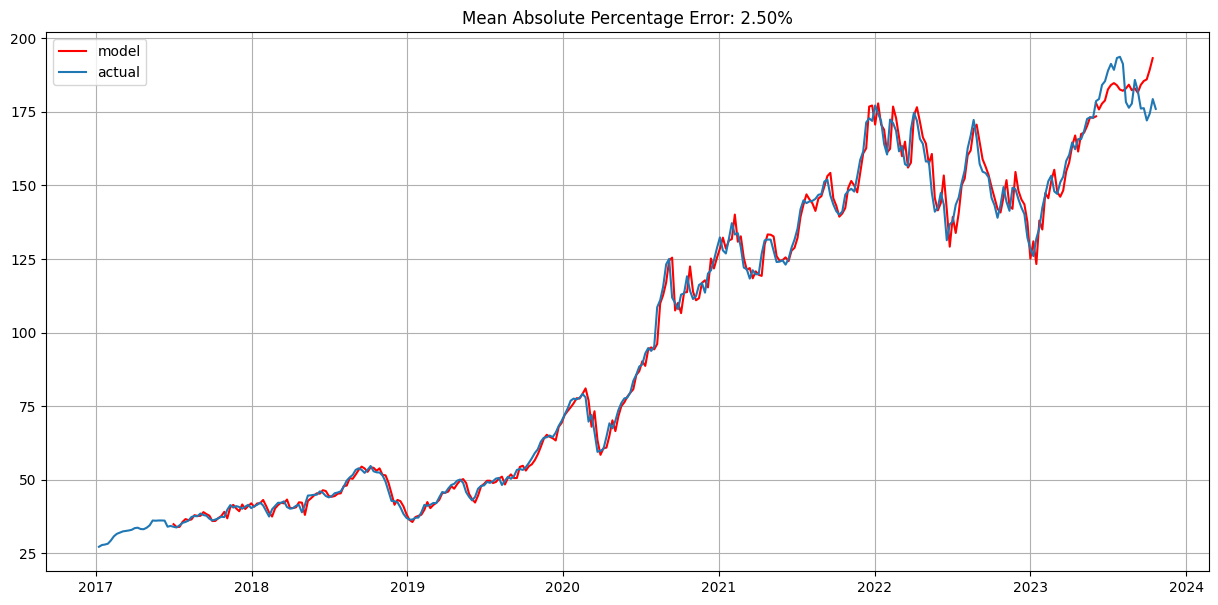

In [13]:
def plotSARIMA(ts, model, n_steps, s=24, d=1):
    data = ts.copy()
    data['arima_model'] = best_model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = model.get_forecast(steps = n_steps)
    prediction_values = forecast.predicted_mean.values

    start_date = str(model.fittedvalues.index[-1])[:10]
    d_range = pd.date_range(start = start_date, periods = n_steps, freq = 'W')
    forecast_series = pd.Series(prediction_values, index = d_range)

    error = mean_absolute_percentage_error(data['Close'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(data.arima_model, color='r', label="model")
    plt.plot(forecast_series, color='r')
    plt.plot(data.Close, label="actual")

    plt.legend()
    plt.grid(True);
    
plotSARIMA(apple_df, best_model, len_test)

To assess the quality of the SARIMA forecast, the MAPE metric was chosen. It is highly interpretable and shows the percentage of errors the model is making. When predicting the next step, the model shows excellent quality, the error is only 2.50 percent. To evaluate the prediction for a longer period than the next step, the validation set was delayed.

As you can see, it was not possible to construct a high-quality forecast for 20 weeks. An increasing trend was not recorded; the model predicted average values over the distance.

We will train the model over the entire length of the time series and build a forecast for the next year.

In [14]:
best_model = sm.tsa.statespace.sarimax.SARIMAX(apple_df, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  355
Model:             SARIMAX(2, 1, 3)x(4, 1, [], 24)   Log Likelihood                -900.642
Date:                             Wed, 01 Nov 2023   AIC                           1821.283
Time:                                     12:46:11   BIC                           1859.274
Sample:                                 01-08-2017   HQIC                          1836.437
                                      - 10-22-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1082     55.276      0.002      0.998    -108.230     108.447
ar.L2          0.5901     3

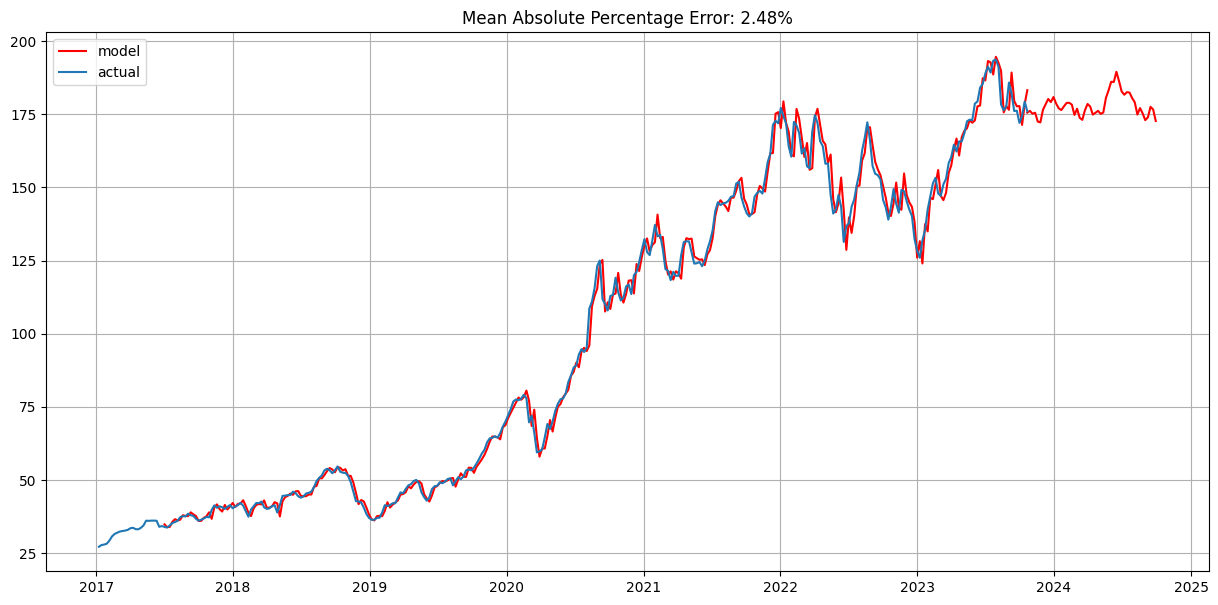

In [15]:
plotSARIMA(apple_df, best_model, 50)

Summary:
- SARIMA model was able to provide a reasonable short-term forecast with a low MAPE.
- For a longer-term forecast, the model assumed average values and did not capture the increasing trend effectively.